<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn

## Standard CNN block
  - Conv, batchNorm, Relu
  

In [18]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, pooling=False, activation=nn.ReLU, groups=1, padding=1, kernel_size=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, groups=groups),
            nn.BatchNorm2d(out_channels),
            activation()
        )
        if pooling:
            self.net.add_module("pooling", nn.MaxPool2d(2))

    def forward(self, x):
      return self.net(x)

t = torch.randn((1, 3, 28, 28)).float()
conv = ConvBlock(3, 10)
conv(t).shape


torch.Size([1, 10, 28, 28])

## ResBlock
  - WHat was new ?
    - Add input to output. Useful to build deep networks by allowing gradient propagation
    - Use shortcut to match shape of input with output from residual
  - Is it still used ?
    - Yes

In [35]:
class ResidualAdd(nn.Module):
    def __init__(self, block, short_cut=None):
        super().__init__()
        self.block = block
        self.short_cut = short_cut

    def forward(self, x):
      res = self.block(x)
      if self.short_cut:
        x = self.short_cut(x)
      return x + res



res_add = ResidualAdd(ConvBlock(3, 10), short_cut=ConvBlock(3, 10))
res_add(t).shape


torch.Size([1, 10, 28, 28])

## Bottleneck block
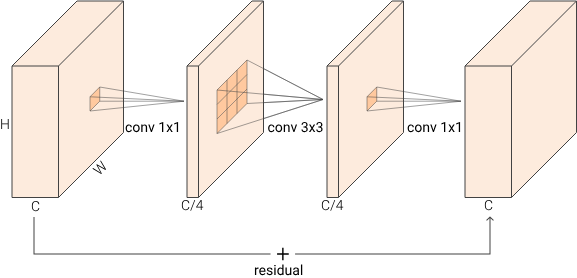

- What was new ?
  - 3 conv layers without bottleneck
    - CONV(C, 3, 3) -> CONV(C, 3, 3) -> CONV(C, 3, 3)
  - 3 conv layers with bottleneck
    - CONV(C/4, 1, 1) -> CONV(C/4, 3, 3) -> CONV(C, 1, 1)
  - Faster than doing 3 convs in channel space
  - Computational cost
    - Standard CNN Cost = (C_i * C_o * W * H * k * k)
    - Old cost = 3 * ( W * H * C * C * 9 ) = 27X
    - New cost = (W * H * C * C)/2 + (W * H *C/4* C/4* 9) = 1.1X
  - For kernel size 3 and bottleneck factor 4, computational cost is reduced by ¬25x.
- Is it still relevant
  - Probably ?


In [28]:
class BottleNeckBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, bottleneck_factor=4):
        super().__init__()
        self.bottleneck_channels = int(out_channels // bottleneck_factor)
        self.block = nn.Sequential(
            ConvBlock(in_channels, self.bottleneck_channels, kernel_size=1, padding=0),
            ConvBlock(self.bottleneck_channels, self.bottleneck_channels, kernel_size=3, padding=1),
            ConvBlock(self.bottleneck_channels, out_channels, kernel_size=1, activation=nn.Identity, padding=0),
        )
        self.net = ResidualAdd(self.block, short_cut=ConvBlock(in_channels, out_channels, kernel_size=1, padding=0))

    def forward(self, x):
      return self.net(x)

t = torch.randn((1, 3, 28, 28)).float()
conv = BottleNeckBlock(3, 10)
conv(t).shape


torch.Size([1, 10, 28, 28])

## MBCONV
- What was new ?
  - aka inverted residual block according to [papersWithCode](https://paperswithcode.com/method/inverted-residual-block)
  - Increase channel resolution and apply depth wise convs in increased channel space
  - $Conv(4*C, 1, 1), CONV(4C, 3, 3, groups=C), CONV(C, 1, 1)$
- Is it still relevant ?
  - no. Depth wise conv is too slow replaced with FusionMBBlock




In [32]:
class MBConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, bottleneck_factor=4):
        super().__init__()
        self.bottleneck_channels = int(out_channels * bottleneck_factor)
        self.block = nn.Sequential(
            ConvBlock(in_channels, self.bottleneck_channels, kernel_size=1, padding=0),
            ConvBlock(self.bottleneck_channels, self.bottleneck_channels, kernel_size=3, padding=1, groups=self.bottleneck_channels),
            ConvBlock(self.bottleneck_channels, out_channels, kernel_size=1, activation=nn.Identity, padding=0),
        )
        self.net = ResidualAdd(self.block, short_cut=ConvBlock(in_channels, out_channels, kernel_size=1, padding=0))

    def forward(self, x):
      return self.net(x)

t = torch.randn((1, 3, 28, 28)).float()
conv = MBConvBlock(3, 10)
conv(t).shape
conv

MBConvBlock(
  (block): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(3, 40, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Identity()
      )
    )
  )
  (net): ResidualAdd(
    (block): Sequential(
      (0): ConvBlock(
        (net): Sequential(
          (0): Conv2d(3, 40, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=Tr

## FusedMBBLOCk
- Depthwise convs are slow, so fuse $1*1$ conv with $3*3$ conv

In [34]:
class FusedMBConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, bottleneck_factor=4):
        super().__init__()
        self.bottleneck_channels = int(out_channels * bottleneck_factor)
        self.block = nn.Sequential(
            ConvBlock(in_channels, self.bottleneck_channels, kernel_size=3, padding=1),
            ConvBlock(self.bottleneck_channels, out_channels, kernel_size=1, activation=nn.Identity, padding=0),
        )
        self.net = ResidualAdd(self.block, short_cut=ConvBlock(in_channels, out_channels, kernel_size=1, padding=0))

    def forward(self, x):
      return self.net(x)

t = torch.randn((1, 3, 28, 28)).float()
conv = FusedMBConvBlock(3, 10)
conv(t).shape
conv

FusedMBConvBlock(
  (block): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Identity()
      )
    )
  )
  (net): ResidualAdd(
    (block): Sequential(
      (0): ConvBlock(
        (net): Sequential(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (net): Sequential(
          (0): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(10, eps=1e-05,